### dependencies

In [ ]:
!pip install chembl-webresource-client node2vec rdkit networkx torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.7 MB/s eta 0:00:00


In [ ]:
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch

In [ ]:
def show_smile(n):
  molecule = new_client.molecule
  mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=n).only('molecule_chembl_id')
  m1 = molecule.filter(chembl_id=mols[0]['molecule_chembl_id']).only(['molecule_chembl_id', 'pref_name', 'molecule_structures'])
  image = new_client.image
  image.set_format('svg')
  return SVG(image.get(mols[0]['molecule_chembl_id']))

def show_smiles(molecule_synonyms):
    molecule = new_client.molecule
    mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=molecule_synonyms).only('molecule_chembl_id')
    m1 = molecule.filter(chembl_id=mols[0]['molecule_chembl_id']).only(['molecule_chembl_id', 'pref_name', 'molecule_structures'])

    smiles = m1[0]['molecule_structures']['canonical_smiles']
    print(f"SMILES for {m1[0]['pref_name']}: {smiles}")

    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    plt.imshow(img)
    plt.show()

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), element=atom.GetSymbol())

    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())

    return G


# Define and train a GCN
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 64)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Final

## For molecule_synonyms__molecule_synonym__iexact and create embeddings

In [ ]:
name = 'Lisinopril'

### 2. Query ChEMBL for Molecules
Using the chembl_webresource_client:


### 3. Extract SMILES Strings
For each molecule, extract the SMILES string:

In [ ]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print("Available resources:", available_resources)

molecule = new_client.molecule
mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=name)

for mol in mols:
    print(mol)


smiles = [mol['molecule_structures']['canonical_smiles'] for mol in mols if 'molecule_structures' in mol]
print("SMILES:", smiles)

if not smiles: raise ValueError(f"No molecules found with molecule_synonyms__molecule_synonym__iexact={name}")

Available resources: ['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'chembl_release', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_classification', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']
{'atc_classifications': ['C09AA03'], 'availability_type': 1, 'biotherapeutic': None, 'black_box_warning': 1, 'chebi_par_id': 6503, 'chemical_probe': 0, 'chirality': 1, 'cross_references': [{'xref_id': 'lisinopril', 'xref_name': 'lisinopril', 'xref_src': 'DailyMed'}, {'xref_id': '11113057', 'xref_name': 'SID: 11113057', 'xref_src': 'PubChem'}, {'xref_id': '170464907', 'xref_name': 'SID: 170464907', 'xref_src': 'PubChe

### 4. Convert SMILES to Graphs
Use RDKit and NetworkX to create molecular graphs:

### 5. Visualize a Molecular Graph
Visualize the graph for better understanding:

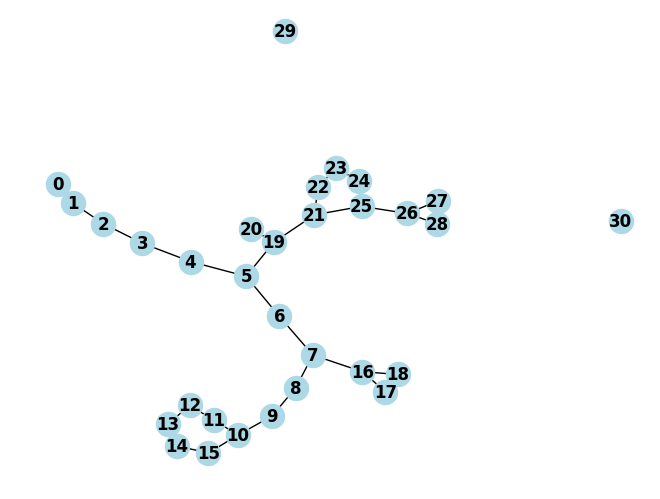

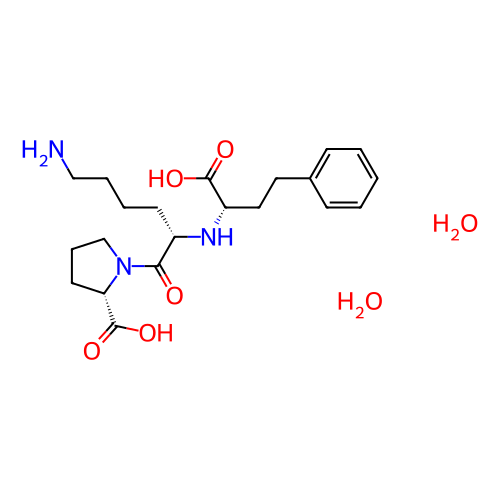

In [ ]:
graphs = [smiles_to_graph(smiles) for smiles in smiles]
G = graphs[0]
nx.draw(G, with_labels=True, node_color="lightblue", font_weight="bold")
plt.show()
show_smile(name)

### 6. Apply Graph Representation Learning (Node2Vec)
Use Node2Vec to generate graph embeddings:

In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

embeddings = {node: model.wv[node] for node in G.nodes()}
print("Node Embeddings for Aspirin Molecule:", embeddings)

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Node Embeddings for Aspirin Molecule: {0: array([ 0.17751445,  0.34844568,  0.18332186,  0.396934  , -0.43856528,
       -0.42333815, -0.03636552,  0.39045224, -0.06388882,  0.05820968,
        0.49586955, -0.18674015,  0.00296145, -0.37937984, -0.03752537,
       -0.12688196,  0.01484798,  0.17804284, -0.3059516 ,  0.20462443,
        0.41134477,  0.03504798,  0.46902025,  0.23073503,  0.01957067,
       -0.01470227, -0.27388382, -0.02449846,  0.05008037,  0.05349442,
       -0.528082  ,  0.44258577,  0.02210394, -0.04185881, -0.16154025,
       -0.00731108,  0.4315101 ,  0.11066965,  0.1245629 ,  0.15390176,
       -0.11756112,  0.28148192, -0.10603832, -0.43629906, -0.20166041,
        0.0327479 , -0.39741498,  0.29220608,  0.02089273,  0.21324809,
        0.13847996,  0.00811428,  0.17807423,  0.39975283,  0.33495012,
        0.04634165,  0.27366447, -0.14909004, -0.19364154,  0.17265958,
        0.07585003,  0.04123041,  0.32717675, -0.12978457], dtype=float32), 1: array([ 0.30927

### Alternative Graph Representation Learning Methods
GCN (Graph Convolutional Networks): Use PyTorch Geometric.

GAT (Graph Attention Networks): Better for complex molecule datasets.

Here’s a PyTorch Geometric example for GCN:

In [ ]:
# Create PyTorch Geometric data object
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(len(G.nodes()))  # One-hot encoding of nodes
data = Data(x=x, edge_index=edge_index)

model = GCN()
out = model(data)
print("GCN Embeddings:", out)


GCN Embeddings: tensor([[ 0.0468,  0.0944, -0.1225,  ..., -0.1471,  0.0252,  0.0860],
        [ 0.0603,  0.0833, -0.0981,  ..., -0.1732,  0.0097,  0.0795],
        [ 0.0322,  0.0233, -0.0357,  ..., -0.0992,  0.0127,  0.0516],
        ...,
        [-0.0891, -0.0351, -0.0361,  ..., -0.0434, -0.0365,  0.1217],
        [-0.0119, -0.0423,  0.0253,  ..., -0.0573,  0.0005,  0.1663],
        [-0.0234,  0.0406,  0.0082,  ...,  0.0391,  0.0927,  0.1832]],
       grad_fn=<AddBackward0>)
